<a href="https://colab.research.google.com/github/rsarpongstreetor/rl/blob/main/Copy_of_Original_work_of_rlfuel_price_ppo_convo_ipynb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

time: 1.87 ms (started: 2024-06-08 09:07:37 +00:00)


In [ ]:
!pip install --upgrade importlib_metadata


# Reinforcement Learning (PPO) with TorchRL Tutorial
**Author**: [Vincent Moens](https://github.com/vmoens)

This tutorial demonstrates how to use PyTorch and :py:mod:`torchrl` to train a parametric policy
network to solve the Inverted Pendulum task from the [OpenAI-Gym/Farama-Gymnasium
control library](https://github.com/Farama-Foundation/Gymnasium)_.

.. figure:: /_static/img/invpendulum.gif
   :alt: Inverted pendulum

   Inverted pendulum

Key learnings:

- How to create an environment in TorchRL, transform its outputs, and collect data from this environment;
- How to make your classes talk to each other using :class:`~tensordict.TensorDict`;
- The basics of building your training loop with TorchRL:

  - How to compute the advantage signal for policy gradient methods;
  - How to create a stochastic policy using a probabilistic neural network;
  - How to create a dynamic replay buffer and sample from it without repetition.

We will cover six crucial components of TorchRL:

* [environments](https://pytorch.org/rl/reference/envs.html)_
* [transforms](https://pytorch.org/rl/reference/envs.html#transforms)_
* [models (policy and value function)](https://pytorch.org/rl/reference/modules.html)_
* [loss modules](https://pytorch.org/rl/reference/objectives.html)_
* [data collectors](https://pytorch.org/rl/reference/collectors.html)_
* [replay buffers](https://pytorch.org/rl/reference/data.html#replay-buffers)_


If you are running this in Google Colab, make sure you install the following dependencies:

```bash
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm
```
Proximal Policy Optimization (PPO) is a policy-gradient algorithm where a
batch of data is being collected and directly consumed to train the policy to maximise
the expected return given some proximality constraints. You can think of it
as a sophisticated version of [REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf),
the foundational policy-optimization algorithm. For more information, see the
[Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347) paper.

PPO is usually regarded as a fast and efficient method for online, on-policy
reinforcement algorithm. TorchRL provides a loss-module that does all the work
for you, so that you can rely on this implementation and focus on solving your
problem rather than re-inventing the wheel every time you want to train a policy.

For completeness, here is a brief overview of what the loss computes, even though
this is taken care of by our :class:`~torchrl.objectives.ClipPPOLoss` module—the algorithm works as follows:
1. we will sample a batch of data by playing the
policy in the environment for a given number of steps.
2. Then, we will perform a given number of optimization steps with random sub-samples of this batch using
a clipped version of the REINFORCE loss.
3. The clipping will put a pessimistic bound on our loss: lower return estimates will
be favored compared to higher ones.
The precise formula of the loss is:

\begin{align}L(s,a,\theta_k,\theta) = \min\left(
    \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
    g(\epsilon, A^{\pi_{\theta_k}}(s,a))
    \right),\end{align}

There are two components in that loss: in the first part of the minimum operator,
we simply compute an importance-weighted version of the REINFORCE loss (for example, a
REINFORCE loss that we have corrected for the fact that the current policy
configuration lags the one that was used for the data collection).
The second part of that minimum operator is a similar loss where we have clipped
the ratios when they exceeded or were below a given pair of thresholds.

This loss ensures that whether the advantage is positive or negative, policy
updates that would produce significant shifts from the previous configuration
are being discouraged.

This tutorial is structured as follows:

1. First, we will define a set of hyperparameters we will be using for training.

2. Next, we will focus on creating our environment, or simulator, using TorchRL's
   wrappers and transforms.

3. Next, we will design the policy network and the value model,
   which is indispensable to the loss function. These modules will be used
   to configure our loss module.

4. Next, we will create the replay buffer and data loader.

5. Finally, we will run our training loop and analyze the results.

Throughout this tutorial, we'll be using the :mod:`tensordict` library.
:class:`~tensordict.TensorDict` is the lingua franca of TorchRL: it helps us abstract
what a module reads and writes and care less about the specific data
description and more about the algorithm itself.




In [ ]:
!pip3 install ipython-autotime
!pip3 install torch
%load_ext autotime
!pip3 install tqdm
!pip3 install tensordict
!pip3 install torchrl
!pip install torchvision
!pip install pydrive
!pip install torchview


from collections import defaultdict
import multiprocessing
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,TransformedEnv )
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm
import google.colab
import pygame
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
import random
import os
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import plotly.express as px
import pandas as pd
google.colab.drive.mount('/content/drive')
from collections import defaultdict
from typing import Optional
import torchrl
import numpy as np

import tqdm
from tensordict import TensorDict, TensorDictBase


from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec,DiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp
import tensordict as td
from torchrl.envs import EnvBase
from torch import  tensor
from torchrl.envs.transforms import TransformedEnv
from tensordict import TensorDict
import tensordict
from torchrl.envs import EnvBase





import collections


time: 1min 18s (started: 2024-06-08 09:42:50 +00:00)


In [ ]:
mghh=DDataenv()

time: 2.06 ms (started: 2024-06-08 09:42:47 +00:00)


In [ ]:
mgh=mghh._get_obs_stats()
print(mgh)

ValueError: iAt based indexing can only have integer indexers

time: 61.5 ms (started: 2024-06-08 09:42:50 +00:00)


In [ ]:
!pip3 install ipython-autotime
!pip3 install torch
%load_ext autotime
!pip3 install tqdm
!pip3 install tensordict
!pip3 install torchrl
!pip install torchvision
!pip install pydrive
!pip install torchview


from collections import defaultdict
import multiprocessing
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,TransformedEnv )
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm
import google.colab
import pygame
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
import random
import os
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import plotly.express as px
import pandas as pd
google.colab.drive.mount('/content/drive')
from collections import defaultdict
from typing import Optional
import torchrl
import numpy as np

import tqdm
from tensordict import TensorDict, TensorDictBase


from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec,DiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp
import tensordict as td
from torchrl.envs import EnvBase
from torch import  tensor
from torchrl.envs.transforms import TransformedEnv
from tensordict import TensorDict
import tensordict
from torchrl.envs import EnvBase





import collections
k=3
class DDataenv():

  #Initialize
  def __init__(self):
    # Load data here
      self.DDDDataDic =np.empty((8,7), dtype=np.float32)
      # We have 3 actions, corresponding to "increase", "decrease", "no change " in fuel price
      #self.action_space = spaces.Discrete(3)
      # Observations are dictionaries with the agent's Observation which are.
      # Forex, Crude oil pric, Fuel price, reward, action
      self.vvmm=np.empty((8,10), dtype=np.float32)
      self.k=k


  def _downl_Data(self):
        with open('/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/DataDic.pt','rb') as rpp:
          DataDic = torch.load(rpp)
        DDataDic=DataDic[0]
        DDDDataDic=DDataDic[:,:,self.k]
        return DDDDataDic

  def _get_obs_stats(self):
        vvmm_dict={},
        vvnn=[]
        vvnv={}
        DD=[]
        DDDataDic=[]
        aadd={}
        aabb=[]
         #observation
        DDDataDic=self._downl_Data()
        observation=DDDataDic[np.random.choice(DDDataDic.shape[0], 1, replace=False),:].numpy().astype(np.float32)
        observation.flatten()
        aabb=pd.DataFrame(observation)
        aabb.columns=['Forex','WTI','Brent','OPEC','Fuelprice','reward0','reward1','reward2','reward3','reward4','action0','action1','action2','action3','action4']
        aadd=aabb.to_dict(orient='list')

        #observation statistics

        DD = DDDataDic.clone()
        DD.reshape(-1, DD.shape[-1])
        vvmm=np.zeros((8,DD.shape[1]))
        df = pd.DataFrame(DD)

        vvmm = df.describe()
        vvmm.columns=['Forex','WTI','Brent','OPEC','Fuelprice','reward0','reward1','reward2','reward3','reward4','action0','action1','action2','action3','action4']
        vvmm.index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
        ii= [3, 7]
       # vvmm.astype(dtype=np.float32, copy=True, errors='list')
        xx=[]
        yy=[]
        xxx=[]
        yyy=[]
        vvvv=[]

        for k in range(len(vvmm.columns)):
          for i in ii:
            xx.append(vvmm.iat[i, k])


        for k in range(len(vvmm.columns)):
          for i in ii:
            yy.append(str(vvmm.index[i]) + '_' + str(vvmm.columns[k]))

        xx=np.array(xx)
        xx = xx.reshape(1, 30)
        yyy=iter(yy)
        vvnn=pd.DataFrame(xx,dtype=np.float32)

        vvnn.columns=yyy
        vvmm_dict= vvnn.to_dict(orient='list')
        return aadd|vvmm_dict




def _step(tensordict):
    Fuelprice, action, reward, Forex, WTI, Brent, OPEC =torch.empty(1,),torch.empty(1,),torch.empty(1,),torch.empty(1,),torch.empty(1,),torch.empty(1,),torch.empty(1,)

    Fuelprice=tensordict['params','Fuelprice'].clone().detach(),
    Forex=tensordict["params","Forex"].clone().detach(),
    WTI=tensordict["params","WTI"].clone().detach(),
    Brent=tensordict["params","Brent"].clone().detach(),
    OPEC=tensordict["params",'OPEC'].clone().detach(),
    action0= tensordict['params',"action"].clone().detach(),
    action1= tensordict['params',"action"].clone().detach(),
    action2= tensordict['params',"action"].clone().detach(),
    action3= tensordict['params',"action"].clone().detach(),
    action4= tensordict['params',"action"].clone().detach(),
    reward0 =tensordict['params',"reward"].clone().detach(),
    reward1 =tensordict['params',"reward"].clone().detach(),
    reward2 =tensordict['params',"reward"].clone().detach(),
    reward3 =tensordict['params',"reward"].clone().detach(),
    reward4 =tensordict['params',"reward"].clone().detach(),


    action0=torch.tensor(action,dtype=torch.float),
    action1=torch.tensor(action,dtype=torch.float),
    action2=torch.tensor(action,dtype=torch.float),
    action3=torch.tensor(action,dtype=torch.float),
    action4=torch.tensor(action,dtype=torch.float),


    reward0=torch.tensor(reward,dtype=torch.float),
    reward1=torch.tensor(reward,dtype=torch.float),
    reward2=torch.tensor(reward,dtype=torch.float),
    reward3=torch.tensor(reward,dtype=torch.float),
    reward4=torch.tensor(reward,dtype=torch.float),

    Fuelprice=torch.tensor(Fuelprice,dtype=torch.float),
    Forex=torch.tensor(Forex,dtype=torch.float),
    WTI=torch.tensor(WTI,dtype=torch.float),
    Brent=torch.tensor(Brent,dtype=torch.float),
    OPEC=torch.tensor(OPEC,dtype=torch.float),
    #observation= torch.rand((3), dtype=torch.float)



    aa0=torch.add(action0[0],-1,),
    aa1=torch.add(action1[0],-1,),
    aa2=torch.add(action2[0],-1,),
    aa3=torch.add(action3[0],-1,),
    aa4=torch.add(action4[0],-1,),

    rr0=torch.multiply(reward[0], aa0[0]),
    rr1=torch.multiply(reward[0], aa1[0]),
    rr2=torch.multiply(reward[0], aa2[0]),
    rr3=torch.multiply(reward[0], aa3[0]),
    rr4=torch.multiply(reward[0], aa4[0]),

    fx=torch.sub(Forex[0], rr0[0] ),
    ww=torch.sub(WTI[0], rr2[0] ),
    bb=torch.sub(Brent[0], rr1[0] ),
    oo=torch.sub(OPEC[0], rr3[0] ),
    ff=torch.sub(Fuelprice[0], rr4[0] ),

    action=torch.stack([action0[0],action1[0],action2[0],action3[0],action4[0]]),
    reward=torch.stack([rr0[0],rr1[0],rr2[0],rr3[0],rr4[0]])
    done = torch.zeros_like(reward).to(torch.bool),

    print(Forex[0])
    print( WTI[0])
    print(Brent[0])
    print(OPEC[0])
    print(ff[0])
    print(rr[0])
    print(done[0])









    out = TensorDict(
          {
                #"observation":observation,
                "Forex": fx[0],
                "WTI": WTI[0],
                'Brent': Brent[0],
                'OPEC': OPEC[0],
                "Fuelprice":ff[0],
                "params": tensordict["params"],
                "reward":rr[0],
                "done": done[0],


         },
        tensordict.shape,

    )
    return out




def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
      # if no ``tensordict`` is passed, we generate a single set of hyperparameters
      # Otherwise, we assume that the input ``tensordict`` contains all the relevant
      # parameters to get started.

      tensordict = self.gen_params(batch_size=self.batch_size )

      Forex= (torch.rand(tensordict.shape, generator=self.rng, device=self.device) *
              (tensordict['params','max_Forex'].clone().detach()- tensordict['params','min_Forex'].clone().detach()) + tensordict['params','min_Forex'].clone().detach()),

      WTI = (torch.rand(tensordict.shape, generator=self.rng, device=self.device) *
                (tensordict['params','max_WTI'].clone().detach()- tensordict['params','min_WTI'].clone().detach()) + tensordict['params','min_WTI'].clone().detach()),
      Brent = (torch.rand(tensordict.shape, generator=self.rng, device=self.device) *
                  (tensordict['params','max_Brent'].clone().detach()- tensordict['params','min_Brent'].clone().detach()) + tensordict['params','min_Brent'].clone().detach()),
      OPEC = (torch.rand(tensordict.shape, generator=self.rng, device=self.device) *
                (tensordict['params','max_OPEC'].clone().detach()- tensordict['params','min_OPEC'].clone().detach()) + tensordict['params','min_OPEC'].clone().detach()),
      Fuelprice = (torch.rand(tensordict.shape, generator=self.rng, device=self.device) *
                (tensordict['params','max_Fuelprice'].clone().detach()- tensordict['params','min_Fuelprice'].clone().detach()) + tensordict['params','min_Fuelprice'].clone().detach()),

      Forex=torch.tensor(Forex, dtype=torch.float),
       # Forex=tuple_of_tensors_to_tensor(Forex),
      WTI=torch.tensor(WTI, dtype=torch.float),
      # WTI=tuple_of_tensors_to_tensor(WTI),
      Brent=torch.tensor(Brent, dtype=torch.float),
       # Brent=tuple_of_tensors_to_tensor(Brent),
      OPEC=torch.tensor(OPEC, dtype=torch.float),
       # OPEC=tuple_of_tensors_to_tensor(OPEC),
      Fuelprice=torch.tensor(Fuelprice, dtype=torch.float),
      #observation=torch.rand((3), dtype=torch.float)





      # for non batch-locked environments, the input ``tensordict`` shape dictates the number
      # of simulators run simultaneously. In other contexts, the initial
      # random state's shape will depend upon the environment batch-size instead.
      print(Forex[0])
      print( WTI[0])
      print(Brent[0])
      print(OPEC[0])
      print(Fuelprice[0])



      out = TensorDict(
      {
                   # "observation":observation,
                    'Forex':Forex[0],
                    'WTI': WTI[0],
                    'Brent':Brent[0],
                    'OPEC':OPEC[0] ,
                    'Fuelprice':Fuelprice[0],
                    'params': tensordict['params'],
       },
          batch_size=tensordict.shape,
      )
      return out

def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)




# @title Default title text
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
      Forex=BoundedTensorSpec(
              low=td_params['params','min_Forex'],
              high=td_params['params','max_Forex'],
              shape=(1,),
              dtype=torch.float
              ),
      WTI=BoundedTensorSpec(
              low=td_params['params','min_WTI'],
              high=td_params['params','max_WTI'],
              shape=(1,),
              dtype=torch.float
              ),
      Brent=BoundedTensorSpec(
            low=td_params['params','min_Brent'],
            high=td_params['params','max_Brent'],
            shape=(1,),
            dtype=torch.float
            ),
      OPEC=BoundedTensorSpec(
            low=td_params['params','min_OPEC'],
            high=td_params['params','max_OPEC'],
            shape=(1,),
            dtype=torch.float
              ),
      Fuelprice=BoundedTensorSpec(
            low=td_params['params','min_Fuelprice'],
            high=td_params['params','max_Fuelprice'],
            shape=(1,),
            dtype=torch.float
            ),

        # we need to add the ``params`` to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),


    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, ``EnvBase`` expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in iput_spec when
    # `self.action_spec = spec` will be called supported
    self.action_space_spec = BoundedTensorSpec(
        low=td_params['params','min_action'],
        high=td_params['params','max_action'],
        shape=(1,),
        dtype=torch.float
        )
    self.reward__space_spec = BoundedTensorSpec(
        low=td_params['params','min_reward'],
        high=td_params['params','max_reward'],
        shape=(1,),
        dtype=torch.float,
        )
    self.full_action_spec = BoundedTensorSpec(
        low=td_params['params','min_action'],
        high=td_params['params','max_action'],
        shape=(1,),
        dtype=torch.float,
        )








def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite


def gen_params(batch_size=torch.Size()) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
      batch_size = []
    my_object=DDataenv()
    ac=my_object._get_obs_stats()

    td = TensorDict(
        {
            "params": ac,

        },

        [],
    )
    if batch_size:
      td = td.expand(batch_size).contiguous()
    return td




def _set_seed(self, seed:45):
    rng = torch.manual_seed(seed)
    self.rng = rng




class AnFuelpriceEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params =staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed




env = AnFuelpriceEnv()
check_env_specs(env)


print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)
print("reward_spec:", env.reward_spec)
td = env.reset()
print("reset tensordict", td)



is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0,1)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 64  # number of cells in each layer i.e. output dim.
lr = 0.1
max_grad_norm = 1.0




td = env.rand_step(td)
print("random step tensordict", td)

#PPO parameters
frames_per_batch = 612
# For a complete training, bring the number of frames up to 1M
total_frames = 10_960

#PPO parameters
sub_batch_size = 32  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4




base_env = env

######################################################################
# Transforming an environment
# ---------------------------
#
# Writing environment transforms for stateless simulators is slightly more
# complicated than for stateful ones: transforming an output entry that needs
# to be read at the following iteration requires to apply the inverse transform
# before calling :func:`meth.step` at the next step.
# This is an ideal scenario to showcase all the features of TorchRL's
# transforms!
#
# For instance, in the following transformed environment we ``unsqueeze`` the entries
# ``["th", "thdot"]`` to be able to stack them along the last
# dimension. We also pass them as ``in_keys_inv`` to squeeze them back to their
# original shape once they are passed as input in the next iteration.
#
env = TransformedEnv(
    base_env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=['Forex', 'Brent','OPEC','Fuelprice','WTI'],
        in_keys_inv=['Forex', 'Brent','OPEC','Fuelprice','WTI'],
    ),
)


 #Concatenates the observations onto an "observation" entry.
# ``del_keys=False`` ensures that we keep these values for the next
# iteration.
cat_transform = CatTensors(
    in_keys=['Forex','Brent','WTI','OPEC','Fuelprice'], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)


base_env1=env

env = TransformedEnv(
    base_env1,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=['observation']),
        DoubleToFloat(),
        StepCounter(),
    ),
)
print(env.transform[2])
print(f"Number of transforms: {len(env.transform)}")

env.transform[2].init_stats(num_iter=2800, reduce_dim=0, cat_dim=0,)

print("normalization constant shape:", env.transform[2].loc.shape)
torch.numel(env.transform[2].loc)
normashape=env.transform[2].loc.shape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

ValueError: mount failed

time: 3min (started: 2024-06-08 02:05:46 +00:00)


## Define Hyperparameters

We set the hyperparameters for our algorithm. Depending on the resources
available, one may choose to execute the policy on GPU or on another
device.
The ``frame_skip`` will control how for how many frames is a single
action being executed. The rest of the arguments that count frames
must be corrected for this value (since one environment step will
actually return ``frame_skip`` frames).




### Data collection parameters

> Add blockquote

> Add blockquote

> Add blockquote







When collecting data, we will be able to choose how big each batch will be
by defining a ``frames_per_batch`` parameter. We will also define how many
frames (such as the number of interactions with the simulator) we will allow ourselves to
use. In general, the goal of an RL algorithm is to learn to solve the task
as fast as it can in terms of environment interactions: the lower the ``total_frames``
the better.




### PPO parameters

At each data collection (or batch collection) we will run the optimization
over a certain number of *epochs*, each time consuming the entire data we just
acquired in a nested training loop. Here, the ``sub_batch_size`` is different from the
``frames_per_batch`` here above: recall that we are working with a "batch of data"
coming from our collector, which size is defined by ``frames_per_batch``, and that
we will further split in smaller sub-batches during the inner training loop.
The size of these sub-batches is controlled by ``sub_batch_size``.




## Define an environment

In RL, an *environment* is usually the way we refer to a simulator or a
control system. Various libraries provide simulation environments for reinforcement
learning, including Gymnasium (previously OpenAI Gym), DeepMind control suite, and
many others.
As a general library, TorchRL's goal is to provide an interchangeable interface
to a large panel of RL simulators, allowing you to easily swap one environment
with another. For example, creating a wrapped gym environment can be achieved with few characters:




There are a few things to notice in this code: first, we created
the environment by calling the ``GymEnv`` wrapper. If extra keyword arguments
are passed, they will be transmitted to the ``gym.make`` method, hence covering
the most common environment construction commands.
Alternatively, one could also directly create a gym environment using ``gym.make(env_name, **kwargs)``
and wrap it in a `GymWrapper` class.

Also the ``device`` argument: for gym, this only controls the device where
input action and observed states will be stored, but the execution will always
be done on CPU. The reason for this is simply that gym does not support on-device
execution, unless specified otherwise. For other libraries, we have control over
the execution device and, as much as we can, we try to stay consistent in terms of
storing and execution backends.

### Transforms

We will append some transforms to our environments to prepare the data for
the policy. In Gym, this is usually achieved via wrappers. TorchRL takes a different
approach, more similar to other pytorch domain libraries, through the use of transforms.
To add transforms to an environment, one should simply wrap it in a :class:`~torchrl.envs.transforms.TransformedEnv`
instance and append the sequence of transforms to it. The transformed environment will inherit
the device and meta-data of the wrapped environment, and transform these depending on the sequence
of transforms it contains.

### Normalization

The first to encode is a normalization transform.
As a rule of thumbs, it is preferable to have data that loosely
match a unit Gaussian distribution: to obtain this, we will
run a certain number of random steps in the environment and compute
the summary statistics of these observations.

We'll append two other transforms: the :class:`~torchrl.envs.transforms.DoubleToFloat` transform will
convert double entries to single-precision numbers, ready to be read by the
policy. The :class:`~torchrl.envs.transforms.StepCounter` transform will be used to count the steps before
the environment is terminated. We will use this measure as a supplementary measure
of performance.

As we will see later, many of the TorchRL's classes rely on :class:`~tensordict.TensorDict`
to communicate. You could think of it as a python dictionary with some extra
tensor features. In practice, this means that many modules we will be working
with need to be told what key to read (``in_keys``) and what key to write
(``out_keys``) in the ``tensordict`` they will receive. Usually, if ``out_keys``
is omitted, it is assumed that the ``in_keys`` entries will be updated
in-place. For our transforms, the only entry we are interested in is referred
to as ``"observation"`` and our transform layers will be told to modify this
entry and this entry only:




As you may have noticed, we have created a normalization layer but we did not
set its normalization parameters. To do this, :class:`~torchrl.envs.transforms.ObservationNorm` can
automatically gather the summary statistics of our environment:




The :class:`~torchrl.envs.transforms.ObservationNorm` transform has now been populated with a
location and a scale that will be used to normalize the data.

Let us do a little sanity check for the shape of our summary stats:




An environment is not only defined by its simulator and transforms, but also
by a series of metadata that describe what can be expected during its
execution.
For efficiency purposes, TorchRL is quite stringent when it comes to
environment specs, but you can easily check that your environment specs are
adequate.
In our example, the :class:`~torchrl.envs.libs.gym.GymWrapper` and
:class:`~torchrl.envs.libs.gym.GymEnv` that inherits
from it already take care of setting the proper specs for your environment so
you should not have to care about this.

Nevertheless, let's see a concrete example using our transformed
environment by looking at its specs.
There are three specs to look at: ``observation_spec`` which defines what
is to be expected when executing an action in the environment,
``reward_spec`` which indicates the reward domain and finally the
``input_spec`` (which contains the ``action_spec``) and which represents
everything an environment requires to execute a single step.




In [ ]:
#print("observation_spec:", env.observation_spec)
#print("reward_spec:", env.reward_spec)
#print("input_spec:", env.input_spec)
#print("action_spec (as defined by input_spec):", env.action_spec)

time: 227 µs (started: 2024-06-06 12:44:12 +00:00)


the :func:`check_env_specs` function runs a small rollout and compares its output against the environment
specs. If no error is raised, we can be confident that the specs are properly defined:




In [ ]:
print("input_spec:", env.input_spec)

input_spec: CompositeSpec(
    full_state_spec: CompositeSpec(
        Forex: BoundedTensorSpec(
            shape=torch.Size([]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        WTI: BoundedTensorSpec(
            shape=torch.Size([]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        Brent: BoundedTensorSpec(
            shape=torch.Size([]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([]), devic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("observation_spec:", env.observation_spec)

observation_spec: CompositeSpec(
    Forex: BoundedTensorSpec(
        shape=torch.Size([1, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    WTI: BoundedTensorSpec(
        shape=torch.Size([1, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    Brent: BoundedTensorSpec(
        shape=torch.Size([1, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=to

In [ ]:

print("reward_spec:", env.reward_spec)

print("action_spec (as defined by input_spec):", env.action_spec)

reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
action_spec (as defined by input_spec): BoundedTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
time: 6.73 ms (started: 2024-06-07 07:49:28 +00:00)


In [ ]:
#check_env_specs(env)

time: 322 µs (started: 2024-06-07 07:32:56 +00:00)


In [ ]:
#print(env.metadata)

time: 304 µs (started: 2024-06-07 07:32:56 +00:00)


For fun, let's see what a simple random rollout looks like. You can
call `env.rollout(n_steps)` and get an overview of what the environment inputs
and outputs look like. Actions will automatically be drawn from the action spec
domain, so you don't need to care about designing a random sampler.

Typically, at each step, an RL environment receives an
action as input, and outputs an observation, a reward and a done state. The
observation may be composite, meaning that it could be composed of more than one
tensor. This is not a problem for TorchRL, since the whole set of observations
is automatically packed in the output :class:`~tensordict.TensorDict`. After executing a rollout
(for example, a sequence of environment steps and random action generations) over a given
number of steps, we will retrieve a :class:`~tensordict.TensorDict` instance with a shape
that matches this trajectory length:




In [ ]:
rollout = env.rollout(10)
#print("rollout of three steps:", rollout)
#print("Shape of the rollout TensorDict:", rollout.batch_size)

tensor([0.7257])
tensor([18.0006])
tensor([126.3810])
tensor([134.9881])
tensor([3.7826])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
tensor([0.])
tensor([False])
tensor([0.6826])
tensor([78.6700])
tensor([83.2000])
tensor([78.7000])
tensor([2.2320])
ten

In [ ]:
print(tensordict)

<module 'tensordict' from '/usr/local/lib/python3.10/dist-packages/tensordict/__init__.py'>
time: 1.48 ms (started: 2024-06-07 07:49:29 +00:00)


Our rollout data has a shape of ``torch.Size([3])``, which matches the number of steps
we ran it for. The ``"next"`` entry points to the data coming after the current step.
In most cases, the ``"next"`` data at time `t` matches the data at ``t+1``, but this
may not be the case if we are using some specific transformations (for example, multi-step).

## Policy

PPO utilizes a stochastic policy to handle exploration. This means that our
neural network will have to output the parameters of a distribution, rather
than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect the
action space boundaries. TorchRL provides such distribution, and the only
thing we need to care about is to build a neural network that outputs the
right number of parameters for the policy to work with (a location, or mean,
and a scale):

\begin{align}f_{\theta}(\text{observation}) = \mu_{\theta}(\text{observation}), \sigma^{+}_{\theta}(\text{observation})\end{align}

The only extra-difficulty that is brought up here is to split our output in two
equal parts and map the second to a strictly positive space.

We design the policy in three steps:

1. Define a neural network ``D_obs`` -> ``2 * D_action``. Indeed, our ``loc`` (mu) and ``scale`` (sigma) both have dimension ``D_action``.

2. Append a :class:`~tensordict.nn.distributions.NormalParamExtractor` to extract a location and a scale (for example, splits the input in two equal parts and applies a positive transformation to the scale parameter).

3. Create a probabilistic :class:`~tensordict.nn.TensorDictModule` that can generate this distribution and sample from it.




In [ ]:
actor_net = nn.Sequential(

    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=1, kernel_size=(3,), stride=(2,), padding=(1,)),
    #nn.Dropout(0.2),
    nn.Tanh(),
    nn.Flatten(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)
policy_module = TensorDictModule(actor_net, in_keys=['observation'], out_keys=["loc", "scale"])



time: 5.83 ms (started: 2024-06-07 07:51:22 +00:00)


We now need to build a distribution out of the location and scale of our
normal distribution. To do so, we instruct the
:class:`~torchrl.modules.tensordict_module.ProbabilisticActor`
class to build a :class:`~torchrl.modules.TanhNormal` out of the location and scale
parameters. We also provide the minimum and maximum values of this
distribution, which we gather from the environment specs.

The name of the ``in_keys`` (and hence the name of the ``out_keys`` from
the :class:`~tensordict.nn.TensorDictModule` above) cannot be set to any value one may
like, as the :class:`~torchrl.modules.TanhNormal` distribution constructor will expect the
``loc`` and ``scale`` keyword arguments. That being said,
:class:`~torchrl.modules.tensordict_module.ProbabilisticActor` also accepts
``Dict[str, str]`` typed ``in_keys`` where the key-value pair indicates
what ``in_key`` string should be used for every keyword argument that is to be used.




In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

time: 5.13 ms (started: 2024-06-07 07:51:26 +00:00)


let's try our policy and value modules. As we said earlier, the usage of
:class:`~tensordict.nn.TensorDictModule` makes it possible to directly read the output
of the environment to run these modules, as they know what information to read
and where to write it:




In [ ]:
value_net = nn.Sequential(

    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=1, kernel_size=(3,), stride=(2,), padding=(1,)),
   #nn.Dropout(0.2),
    nn.Tanh(),
    nn.Flatten(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),)
value_module = ValueOperator(module=value_net,in_keys=["observation"],)

time: 29.3 ms (started: 2024-06-07 07:51:28 +00:00)


time: 609 µs (started: 2024-06-06 12:07:29 +00:00)


In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

tensor([0.6717])
tensor([134.2064])
tensor([65.9501])
tensor([118.7389])
tensor([1.7952])
Running policy: TensorDict(
    fields={
        Brent: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        Forex: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        Fuelprice: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        OPEC: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        WTI: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float3

## Data collector

TorchRL provides a set of [DataCollector classes](https://pytorch.org/rl/reference/collectors.html)_.
Briefly, these classes execute three operations: reset an environment,
compute an action given the latest observation, execute a step in the environment,
and repeat the last two steps until the environment signals a stop (or reaches
a done state).

They allow you to control how many frames to collect at each iteration
(through the ``frames_per_batch`` parameter),
when to reset the environment (through the ``max_frames_per_traj`` argument),
on which ``device`` the policy should be executed, etc. They are also
designed to work efficiently with batched and multiprocessed environments.

The simplest data collector is the :class:`~torchrl.collectors.collectors.SyncDataCollector`:
it is an iterator that you can use to get batches of data of a given length, and
that will stop once a total number of frames (``total_frames``) have been
collected.
Other data collectors (:class:`~torchrl.collectors.collectors.MultiSyncDataCollector` and
:class:`~torchrl.collectors.collectors.MultiaSyncDataCollector`) will execute
the same operations in synchronous and asynchronous manner over a
set of multiprocessed workers.

As for the policy and environment before, the data collector will return
:class:`~tensordict.TensorDict` instances with a total number of elements that will
match ``frames_per_batch``. Using :class:`~tensordict.TensorDict` to pass data to the
training loop allows you to write data loading pipelines
that are 100% oblivious to the actual specificities of the rollout content.




In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

tensor([0.6312])
tensor([69.2428])
tensor([109.7300])
tensor([86.6948])
tensor([0.7559])
time: 86.2 ms (started: 2024-06-07 07:51:37 +00:00)


/usr/local/lib/python3.10/dist-packages/torchrl/collectors/collectors.py:586: UserWarning: total_frames (20960) is not exactly divisible by frames_per_batch (612).This means 460 additional frames will be collected.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


## Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms.
In on-policy contexts, a replay buffer is refilled every time a batch of
data is collected, and its data is repeatedly consumed for a certain number
of epochs.

TorchRL's replay buffers are built using a common container
:class:`~torchrl.data.ReplayBuffer` which takes as argument the components
of the buffer: a storage, a writer, a sampler and possibly some transforms.
Only the storage (which indicates the replay buffer capacity) is mandatory.
We also specify a sampler without repetition to avoid sampling multiple times
the same item in one epoch.
Using a replay buffer for PPO is not mandatory and we could simply
sample the sub-batches from the collected batch, but using these classes
make it easy for us to build the inner training loop in a reproducible way.




In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

time: 3.66 ms (started: 2024-06-07 07:51:42 +00:00)


## Loss function

The PPO loss can be directly imported from TorchRL for convenience using the
:class:`~torchrl.objectives.ClipPPOLoss` class. This is the easiest way of utilizing PPO:
it hides away the mathematical operations of PPO and the control flow that
goes with it.

PPO requires some "advantage estimation" to be computed. In short, an advantage
is a value that reflects an expectancy over the return value while dealing with
the bias / variance tradeoff.
To compute the advantage, one just needs to (1) build the advantage module, which
utilizes our value operator, and (2) pass each batch of data through it before each
epoch.
The GAE module will update the input ``tensordict`` with new ``"advantage"`` and
``"value_target"`` entries.
The ``"value_target"`` is a gradient-free tensor that represents the empirical
value that the value network should represent with the input observation.
Both of these will be used by :class:`~torchrl.objectives.ClipPPOLoss` to
return the policy and value losses.




In [ ]:
advantage_module = GAE(gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(),lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

time: 116 ms (started: 2024-06-07 07:51:44 +00:00)


In [ ]:
!pip install tqdm

time: 6.33 s (started: 2024-06-07 07:51:49 +00:00)


In [ ]:
from tqdm import tqdm

time: 527 µs (started: 2024-06-07 07:51:55 +00:00)


In [ ]:
pbar = tqdm(total=total_frames)

  0%|          | 0/20960 [00:00<?, ?it/s]

time: 7.91 ms (started: 2024-06-07 07:51:55 +00:00)


## Training loop
We now have all the pieces needed to code our training loop.
The steps include:

* Collect data

  * Compute advantage

    * Loop over the collected to compute loss values
    * Back propagate
    * Optimize
    * Repeat

  * Repeat

* Repeat




In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()



  0%|          | 0/20960 [00:00<?, ?it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.


  0%|          | 0/20960 [14:27<?, ?it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])


tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])




  3%|▎         | 612/20960 [00:25<13:56, 24.33it/s]

Streaming output truncated to the last 5000 lines.
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([



  3%|▎         | 612/20960 [00:44<13:56, 24.33it/s]

tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor([67.7000])
tensor([71.8000])
tensor([68.4000])
tensor([3.4200])
tensor([-1.1350])
tensor([False])
tensor([0.6626])
tensor(



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 611, lr policy:  0.1000:   3%|▎         | 612/20960 [00:46<13:56, 24.33it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 611, lr policy:  0.1000:   6%|▌         | 1224/20960 [00:59<16:18, 20.18it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 1223, lr policy:  0.0998:   6%|▌         | 1224/20960 [00:59<16:18, 20.18it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 1223, lr policy:  0.0998:   9%|▉         | 1836/20960 [01:12<11:49, 26.95it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 1835, lr policy:  0.0991:   9%|▉         | 1836/20960 [01:12<11:49, 26.95it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 1835, lr policy:  0.0991:   9%|▉         | 1836/20960 [01:24<11:49, 26.95it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 1835, lr policy:  0.0991:  12%|█▏        | 2448/20960 [01:26<09:38, 32.00it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 2447, lr policy:  0.0981:  12%|█▏        | 2448/20960 [01:26<09:38, 32.00it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 2447, lr policy:  0.0981:  15%|█▍        | 3060/20960 [01:40<08:23, 35.53it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 3059, lr policy:  0.0966:  15%|█▍        | 3060/20960 [01:40<08:23, 35.53it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 3059, lr policy:  0.0966:  15%|█▍        | 3060/20960 [01:54<08:23, 35.53it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 3059, lr policy:  0.0966:  18%|█▊        | 3672/20960 [01:54<07:37, 37.82it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 3671, lr policy:  0.0948:  18%|█▊        | 3672/20960 [01:54<07:37, 37.82it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 3671, lr policy:  0.0948:  20%|██        | 4284/20960 [02:08<07:00, 39.68it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 4283, lr policy:  0.0925:  20%|██        | 4284/20960 [02:08<07:00, 39.68it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 4283, lr policy:  0.0925:  23%|██▎       | 4896/20960 [02:24<06:49, 39.26it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 4895, lr policy:  0.0899:  23%|██▎       | 4896/20960 [02:24<06:49, 39.26it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 4895, lr policy:  0.0899:  23%|██▎       | 4896/20960 [02:34<06:49, 39.26it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 4895, lr policy:  0.0899:  26%|██▋       | 5508/20960 [02:37<06:18, 40.85it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 5507, lr policy:  0.0870:  26%|██▋       | 5508/20960 [02:37<06:18, 40.85it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 5507, lr policy:  0.0870:  29%|██▉       | 6120/20960 [02:51<05:55, 41.76it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6119, lr policy:  0.0837:  29%|██▉       | 6120/20960 [02:51<05:55, 41.76it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6119, lr policy:  0.0837:  29%|██▉       | 6120/20960 [03:04<05:55, 41.76it/s]

eval cumulative reward: -1135.0001 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6119, lr policy:  0.0837:  32%|███▏      | 6732/20960 [03:05<05:35, 42.46it/s]

Streaming output truncated to the last 5000 lines.
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6731, lr policy:  0.0801:  32%|███▏      | 6732/20960 [03:18<05:35, 42.46it/s]  

tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])
tensor([0.6665])
tensor([52.8800])
tensor([54.2500])
tensor([57.9000])
tensor([1.6800])
tensor([-0.0310])
tensor([False])


tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6731, lr policy:  0.0801:  32%|███▏      | 6732/20960 [03:24<05:35, 42.46it/s]


tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 6731, lr policy:  0.0801:  35%|███▌      | 7344/20960 [03:33<06:48, 33.33it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 7343, lr policy:  0.0763:  35%|███▌      | 7344/20960 [03:33<06:48, 33.33it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 7343, lr policy:  0.0763:  35%|███▌      | 7344/20960 [03:44<06:48, 33.33it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 7343, lr policy:  0.0763:  38%|███▊      | 7956/20960 [03:50<06:21, 34.07it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 7955, lr policy:  0.0723:  38%|███▊      | 7956/20960 [03:50<06:21, 34.07it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 7955, lr policy:  0.0723:  41%|████      | 8568/20960 [04:04<05:39, 36.51it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 8567, lr policy:  0.0681:  41%|████      | 8568/20960 [04:04<05:39, 36.51it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 8567, lr policy:  0.0681:  41%|████      | 8568/20960 [04:14<05:39, 36.51it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 8567, lr policy:  0.0681:  44%|████▍     | 9180/20960 [04:18<05:11, 37.82it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 9179, lr policy:  0.0637:  44%|████▍     | 9180/20960 [04:18<05:11, 37.82it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 9179, lr policy:  0.0637:  47%|████▋     | 9792/20960 [04:32<04:42, 39.47it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 9791, lr policy:  0.0592:  47%|████▋     | 9792/20960 [04:32<04:42, 39.47it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 9791, lr policy:  0.0592:  47%|████▋     | 9792/20960 [04:44<04:42, 39.47it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 9791, lr policy:  0.0592:  50%|████▉     | 10404/20960 [04:46<04:19, 40.62it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 10403, lr policy:  0.0546:  50%|████▉     | 10404/20960 [04:46<04:19, 40.62it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 10403, lr policy:  0.0546:  53%|█████▎    | 11016/20960 [05:01<04:04, 40.59it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11015, lr policy:  0.0500:  53%|█████▎    | 11016/20960 [05:02<04:04, 40.59it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11015, lr policy:  0.0500:  53%|█████▎    | 11016/20960 [05:14<04:04, 40.59it/s]

tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11015, lr policy:  0.0500:  55%|█████▌    | 11628/20960 [05:20<04:07, 37.67it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11627, lr policy:  0.0454:  55%|█████▌    | 11628/20960 [05:20<04:07, 37.67it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11627, lr policy:  0.0454:  55%|█████▌    | 11628/20960 [05:34<04:07, 37.67it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 11627, lr policy:  0.0454:  58%|█████▊    | 12240/20960 [05:34<03:41, 39.41it/s]

eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 12239, lr policy:  0.0408:  58%|█████▊    | 12240/20960 [05:34<03:41, 39.41it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -31.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 12239, lr policy:  0.0408:  61%|██████▏   | 12852/20960 [05:49<03:20, 40.41it/s]

Streaming output truncated to the last 5000 lines.
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])
tensor([73.3300])
tensor([76.])
tensor([71.7500])
tensor([2.3510])
tensor([0.])
tensor([False])
tensor([0.7495])



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 12851, lr policy:  0.0363:  61%|██████▏   | 12852/20960 [06:01<03:20, 40.41it/s] 

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 12851, lr policy:  0.0363:  61%|██████▏   | 12852/20960 [06:04<03:20, 40.41it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 12851, lr policy:  0.0363:  64%|██████▍   | 13464/20960 [06:15<03:46, 33.14it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 13463, lr policy:  0.0319:  64%|██████▍   | 13464/20960 [06:15<03:46, 33.14it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 13463, lr policy:  0.0319:  67%|██████▋   | 14076/20960 [06:28<03:11, 35.95it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 14075, lr policy:  0.0277:  67%|██████▋   | 14076/20960 [06:28<03:11, 35.95it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 14075, lr policy:  0.0277:  70%|███████   | 14688/20960 [06:42<02:43, 38.44it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 14687, lr policy:  0.0237:  70%|███████   | 14688/20960 [06:42<02:43, 38.44it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 14687, lr policy:  0.0237:  70%|███████   | 14688/20960 [06:54<02:43, 38.44it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 14687, lr policy:  0.0237:  73%|███████▎  | 15300/20960 [06:56<02:21, 39.93it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 15299, lr policy:  0.0199:  73%|███████▎  | 15300/20960 [06:56<02:21, 39.93it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 15299, lr policy:  0.0199:  76%|███████▌  | 15912/20960 [07:10<02:04, 40.69it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 15911, lr policy:  0.0163:  76%|███████▌  | 15912/20960 [07:10<02:04, 40.69it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 15911, lr policy:  0.0163:  79%|███████▉  | 16524/20960 [07:24<01:46, 41.77it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 16523, lr policy:  0.0130:  79%|███████▉  | 16524/20960 [07:24<01:46, 41.77it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 16523, lr policy:  0.0130:  79%|███████▉  | 16524/20960 [07:34<01:46, 41.77it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 16523, lr policy:  0.0130:  82%|████████▏ | 17136/20960 [07:38<01:30, 42.43it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 17135, lr policy:  0.0101:  82%|████████▏ | 17136/20960 [07:38<01:30, 42.43it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 17135, lr policy:  0.0101:  85%|████████▍ | 17748/20960 [07:52<01:14, 42.95it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 17747, lr policy:  0.0075:  85%|████████▍ | 17748/20960 [07:52<01:14, 42.95it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 17747, lr policy:  0.0075:  85%|████████▍ | 17748/20960 [08:04<01:14, 42.95it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 17747, lr policy:  0.0075:  88%|████████▊ | 18360/20960 [08:07<01:01, 42.13it/s]

eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 18359, lr policy:  0.0052:  88%|████████▊ | 18360/20960 [08:07<01:01, 42.13it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 18359, lr policy:  0.0052:  91%|█████████ | 18972/20960 [08:21<00:47, 42.18it/s]

Streaming output truncated to the last 5000 lines.
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tens



eval cumulative reward:  0.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 18359, lr policy:  0.0052:  91%|█████████ | 18972/20960 [08:34<00:47, 42.18it/s]

tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])
tensor([0.6482])
tensor([106.7900])
tensor([109.8000])
tensor([104.7500])
tensor([2.8680])
tensor([-0.0480])
tensor([False])




eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 18971, lr policy:  0.0034:  91%|█████████ | 18972/20960 [08:35<00:47, 42.18it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 18971, lr policy:  0.0034:  93%|█████████▎| 19584/20960 [08:50<00:41, 32.80it/s]

eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 19583, lr policy:  0.0019:  93%|█████████▎| 19584/20960 [08:50<00:41, 32.80it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 19583, lr policy:  0.0019:  96%|█████████▋| 20196/20960 [09:04<00:21, 35.35it/s]

eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 20195, lr policy:  0.0009:  96%|█████████▋| 20196/20960 [09:04<00:21, 35.35it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 20195, lr policy:  0.0009:  96%|█████████▋| 20196/20960 [09:14<00:21, 35.35it/s]

eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 20195, lr policy:  0.0009:  99%|█████████▉| 20808/20960 [09:18<00:04, 37.21it/s]

eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 20807, lr policy:  0.0002:  99%|█████████▉| 20808/20960 [09:18<00:04, 37.21it/s]

tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.2700])
tensor([0.8020])
tensor([0.])
tensor([False])
tensor([0.7203])
tensor([25.9400])
tensor([26.5200])
tensor([28.



eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 20807, lr policy:  0.0002: : 21420it [09:32, 38.81it/s]                         

eval cumulative reward: -48.0000 (init: -1135.0001), eval step-count: 999, average reward= 0.0000 (init= 0.0000), step count (max): 21419, lr policy:  0.0000: : 21420it [09:32, 38.81it/s]

time: 9min 32s (started: 2024-06-07 07:51:55 +00:00)


## Results

Before the 1M step cap is reached, the algorithm should have reached a max
step count of 1000 steps, which is the maximum number of steps before the
trajectory is truncated.




In [ ]:
# ... (existing code)

# Check if the "state_value" key is present in the tensordict_data object
if "state_value" in tensordict_data:
    # Call the advantage_module as usual
    advantage_module(tensordict_data)
else:
    # Handle the missing key gracefully
    # For example, you could print a warning message or skip the current iteration
    print("Warning: 'state_value' key not found in tensordict_data")

# ... (remaining code)

time: 67.9 ms (started: 2024-06-07 08:01:28 +00:00)


In [ ]:
print(tensordict_data)

TensorDict(
    fields={
        Brent: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        Forex: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        Fuelprice: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        OPEC: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        WTI: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([612, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([612, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([612]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([612]),
            device=cpu,
            is_sha

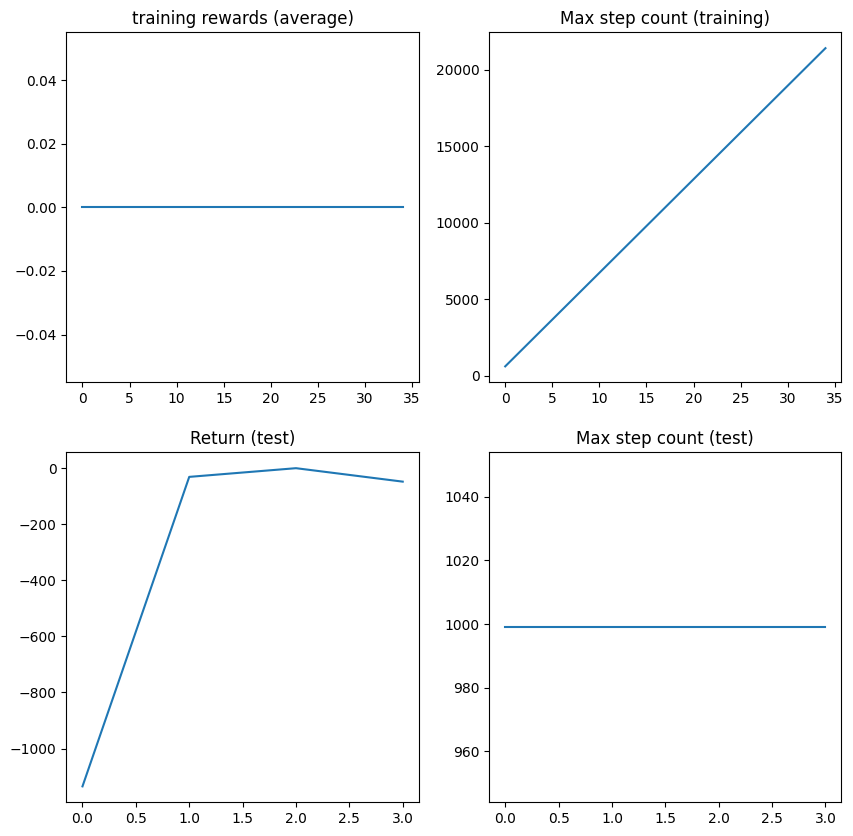

time: 704 ms (started: 2024-06-07 08:13:26 +00:00)


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

## Conclusion and next steps

In this tutorial, we have learned:

1. How to create and customize an environment with :py:mod:`torchrl`;
2. How to write a model and a loss function;
3. How to set up a typical training loop.

If you want to experiment with this tutorial a bit more, you can apply the following modifications:

* From an efficiency perspective,
  we could run several simulations in parallel to speed up data collection.
  Check :class:`~torchrl.envs.ParallelEnv` for further information.

* From a logging perspective, one could add a :class:`torchrl.record.VideoRecorder` transform to
  the environment after asking for rendering to get a visual rendering of the
  inverted pendulum in action. Check :py:mod:`torchrl.record` to
  know more.




### Saving Models

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH1 = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/State_dict_model1.pt'
PATH = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/model.pt'
torch.save({'actor_net_state_dict': policy_module.state_dict(),
    'value_net_state_dict': value_module.state_dict(),

}, PATH1)

torch.save({policy_module, value_module}, PATH)

Mounted at /content/drive
time: 4.35 s (started: 2024-06-07 08:13:41 +00:00)


## Loading Models


In [ ]:

# Load
PATH = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/model.pt'

policy_module, value_module = torch.load(PATH)



time: 16.9 ms (started: 2024-06-07 08:13:46 +00:00)


In [ ]:
policy_module.eval()


ProbabilisticActor(
    module=ModuleList(
      (0): TensorDictModule(
          module=Sequential(
            (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
            (1): Tanh()
            (2): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            (3): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
            (4): Tanh()
            (5): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            (6): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
            (7): Tanh()
            (8): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            (9): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
            (10): Tanh()
            (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            (12): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
            (13): Tanh()
            (14): MaxPool1d

time: 5.44 ms (started: 2024-06-07 08:13:54 +00:00)


In [ ]:
value_module.eval()

ValueOperator(
    module=Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Tanh()
      (2): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (4): Tanh()
      (5): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): Tanh()
      (8): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (9): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (10): Tanh()
      (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (12): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (13): Tanh()
      (14): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (15): Conv1d(64, 1, kernel_size=(3,), stride=(2,), padding=(1,))
      (16): Tanh(

time: 4.51 ms (started: 2024-06-07 08:13:58 +00:00)




## Inference coding

In [ ]:
k=3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import collections
import numpy as np
import torch
from google.colab import drive
drive.mount('/content/drive')

DDDDataDic =np.empty((8,7), dtype=np.float32)
# We have 3 actions, corresponding to "increase", "decrease", "no change " in fuel price
#self.action_space = spaces.Discrete(3)
# Observations are dictionaries with the agent's Observation which are.
# Forex, Crude oil pric, Fuel price, reward, action



with open('/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/DataDic.pt','rb') as rpp:
  DataDic = torch.load(rpp)
DDataDic=DataDic[0]
DDDDataDic=DDataDic[:,:,k]
print(DDDDataDic)

DDDDataDic_array = DDDDataDic.numpy()
DDDDataDic_df = pd.DataFrame(DDDDataDic_array)
DDDDataDic_df.to_csv('/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/MatlabARIMAXAData.csv')

n = len(DDDDataDic_df)
# Create a DatetimeIndex with 7795 dates
iddx=pd.date_range(start='2003-01-02', periods=n, freq='D')
# Assign the DatetimeIndex to the 'date' column of DDDDataDic_df
# Set the 'date' column as the index of DDDDataDic_df
DDDDataDic_df.index = iddx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tensor([[ 0.7401, 30.8300, 31.4400,  ...,  0.5730,  0.0000,  1.0000],
        [ 0.7401, 30.8300, 31.4400,  ...,  0.5730,  0.0000,  2.0000],
        [ 0.7401, 30.8300, 31.4400,  ...,  0.5730,  0.3120,  0.0000],
        ...,
        [ 0.7554, 88.3900, 83.2000,  ...,  2.3960,  0.0000,  1.0000],
        [ 0.7554, 88.3900, 83.2000,  ...,  2.3960,  0.0000,  2.0000],
        [ 0.7545, 88.3900, 83.2000,  ...,  2.3960,  1.3962,  0.0000]])
time: 3.99 s (started: 2024-06-07 08:14:02 +00:00)


In [ ]:
#########
DDDDataDic_df
DDDDataDic_df.columns = ['US$_SDR', 'Brent', 'WTI','OPEC','Fuelprice','Rewards','Actions']
#Selected attribute and target variables
x =DDDDataDic_df[['US$_SDR', 'Brent', 'WTI','OPEC']]
y = DDDDataDic_df['Fuelprice']

time: 16.7 ms (started: 2024-06-07 08:14:16 +00:00)


In [ ]:
# Define the number of future time steps to forecast
num_forecast_steps = 30
import pandas as pd

# Assuming DDDDataDic_df is a pandas DataFrame with a DatetimeIndex
last_date_30_Daysb = DDDDataDic_df.index[-1] - pd.Timedelta(days=num_forecast_steps)
historical_data=DDDDataDic_df
historical_data = DDDDataDic_df.loc[last_date_30_Daysb:]
# we use the observation data historical_data =["US$_SDR", "Brent", "WTI","OPEC", "Fuelprice"]for the forecasting
historical_data_obs = historical_data.columns[0:5]
#print(historical_data_obs)

# Convert to NumPy and remove singleton dimensions
#sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
#historical_data_obs= sequence_to_plot[-1]
print(historical_data_obs.shape)

# Initialize a list to store the forecasted values
forecasted_values = []
forecasted_actions = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps*2):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data_obs).view(1,5).float().to(device)
		# Use the model to predict the next value
		predicted_value = value_module(historical_data_tensor)
		predicted_actions =policy_module(historical_data_tensor)

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])
		forecasted_actions.append(predicted_actions[0])
		forecasted_reward=predicted_value[Fuelprice]-historical_data_obs[Fuelprice]

		predicted_valueful=concat([predicted_value,forecasted_reward,predicted_actions])




		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_valueful




# Generate futute date
last_datea =historical_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = historical_data.index.append(future_dates)


(5,)


ValueError: too many dimensions 'str'

time: 52.2 ms (started: 2024-06-07 09:18:30 +00:00)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
num_cells = 64
device = torch.device
action_spec.shape[-1]=env.action_spec.shape[-1]

class Net(torch.nn.Module):
   def __init__(self):
        super(Net,self,).__init__()
        self.FF3=nn.Linear(num_cells,1,device=device)
        self.conv1d=nn.LazyConv1d(out_channels=num_cells, kernel_size=3, stride=2, padding=1,)
        self.maxpool1=nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
        self.FFF=nn.Flatten(start_dim=-1,end_dim=1)
        self.FF=nn.LazyLinear(num_cells,device=device)
        self.FF2=nn.LazyLinear(2 * env.action_spec.shape[-1], device=device)
        self.tanh=nn.Tanh()
        self.FF1=nn.LazyLinear(1,device=device)
        self.NPE=NormalParamExtractor()
        self.w = torch.empty(num_cells)

   def forward(self,x):
        x=self.FF3(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.FFF(x)
        x =self.FF(x)
        x=self.tanh(x)
        x =self.FF(x)
        x=self.tanh(x)
        x =self.FF2(x)
        x =self.NPE(x)
        return x
net=Net()
print(net)





Mounted at /content/drive


NameError: name 'action_spec' is not defined

time: 3.73 s (started: 2024-06-01 14:18:54 +00:00)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

In [ ]:
class new_value_net(torch.nn.Module):
   def __init__(self):
        super(new_value_net,self,).__init__()
        self.FF3=nn.Linear(num_cells,1,device=device)
        self.conv1d=nn.LazyConv1d(out_channels=num_cells, kernel_size=3, stride=2, padding=1,)
        self.maxpool1=nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
        self.FFF=nn.Flatten(start_dim=-1,end_dim=1)
        self.FF=nn.LazyLinear(num_cells,device=device)
        self.FF2=nn.LazyLinear(2 * env.action_spec.shape[-1], device=device)
        self.tanh=nn.Tanh()
        self.FF1=nn.LazyLinear(1,device=device)
        self.NPE=NormalParamExtractor()
        self.w = torch.empty(num_cells)

   def forward(self,x):
        x=nn.init.constant_(self.w, 0.3)
        x=self.FF3(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.conv1d(x)
        x =self.maxpool1(x)
        x=self.tanh(x)
        x =self.FFF(x)
        x =self.FF(x)
        x=self.tanh(x)
        x =self.FF(x)
        x=self.tanh(x)
        x =self.FF1
        return x
new_value_net=new_value_net()
new_value_net=new_value_net.float






NameError: name 'torch' is not defined

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

Nactor_net = Net()
Nvalue_net = Net()

In [ ]:
new_value_net = nn.Sequential(

    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=num_cells, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True),
    nn.LazyConv1d(out_channels=1, kernel_size=(3,), stride=(2,), padding=(1,)),
    nn.Tanh(),
    nn.Flatten(),
    nn.LazyLinear(frames_per_batch, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),)
value_module = ValueOperator(module=new_value_net,in_keys=["observation"],)

time: 8.6 ms (started: 2024-06-01 08:25:54 +00:00)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




PATH = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/model.pt'

checkpoint = torch.load(PATH)

new_actor_net_dict = model.state_dict()
new_value_net_dict = model.state_dict()


pretrained_weights_new_actor_net= {}
pretrained_weights_new_value_net= {}


for key, value in checkpoint['actor_net_state_dict'].items():
    new_key = key.replace('module.', '')
    pretrained_weights_new_actor_net[new_key] = value

#new_value_net_state_dict = {}
for key, value in checkpoint['value_net_state_dict'].items():
    new_key1 = key.replace('module.', '')
    pretrained_weights_new_value_net[new_key1] = value

new_actor_net_dict.update(pretrained_weights_new_actor_net)
new_value_net_dict.update(pretrained_weights_new_value_net)

model.load_state_dict(pretrained_weights_new_actor_net, strict = False)
model.load_state_dict(pretrained_weights_new_value_net, strict = False)





Mounted at /content/drive


NameError: name 'model' is not defined

time: 7.6 s (started: 2024-06-01 11:12:18 +00:00)


In [ ]:
pretrained_path = torch.load(path to pretrained model)


new_model_dict = model.state_dict()

pretrained_weights = { k:v for k , v in pretrained_path.items() if k in new_model_dict}

new_model_dict.update(pretrained_weights)

model.load_state_dict(pretrained_weights, strict = False)

In [ ]:
new_model_dict.update(pretrained_weights)

In [ ]:
new_value_net.load_state_dict(new_value_net_state_dict)
new_actor_net.load_state_dict(new_actor_net_state_dict)

NameError: name 'new_value_net_state_dict' is not defined

time: 24.4 ms (started: 2024-06-01 08:32:57 +00:00)


In [ ]:
new_value_net.update(new_value_net_state_dict)
new_actor_net.update(new_actor_net_state_dict)

AttributeError: 'Sequential' object has no attribute 'update'

time: 19.3 ms (started: 2024-06-01 08:29:00 +00:00)


In [ ]:
print(new_actor_net)

{'0.0.weight': tensor([[[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

     

In [ ]:
print(new_value_net)

{'0.weight': tensor([[[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

       

Forecasting With models

In [ ]:
!pip install graphviz
!pip install torchviz

In [ ]:
!pip install torchview

time: 29 s (started: 2024-05-21 12:41:54 +00:00)


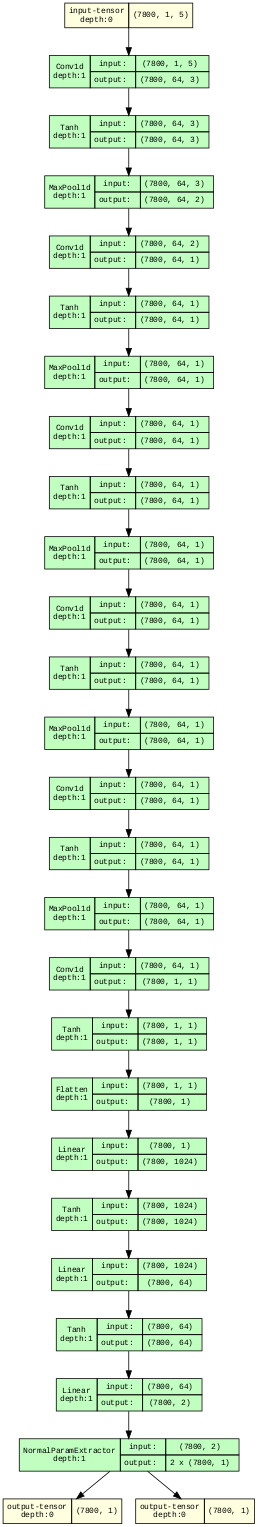

time: 669 ms (started: 2024-05-21 12:44:51 +00:00)


In [ ]:
from torchview import draw_graph
batch_size = frames_per_batch

model_graph = draw_graph(actor_net, input_size=(7800,1,5), device=device)
model_graph.visual_graph

# device='meta' -> no memory is consumed for visualization
#model_graph1 = draw_graph(value_net, input_size=(780,1,5), device=device)
#model_graph1.visual_graph



In [ ]:
import graphviz
graphviz.set_jupyter_format('png')
#graphviz.Source(model_graph1.visual_graph)
graphviz.Source(model_graph.visual_graph)

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
model_graph = draw_graph(actor_net, input_size=(7800,1,5), device=device)

time: 382 ms (started: 2024-05-21 12:50:06 +00:00)


In [ ]:
print(model_graph.visual_graph)

strict digraph model {
	graph [ordering=in rankdir=TB size="15.899999999999999,15.899999999999999"]
	node [align=left fontname="Linux libertine" fontsize=10 height=0.2 margin=0 ranksep=0.1 shape=plaintext style=filled]
	edge [fontsize=10]
	0 [label=<
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                        <TR><TD>input-tensor<BR/>depth:0</TD><TD>(7800, 1, 5)</TD></TR>
                    </TABLE>> fillcolor=lightyellow]
	1 [label=<
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                    <TR>
                        <TD ROWSPAN="2">Conv1d<BR/>depth:1</TD>
                        <TD COLSPAN="2">input:</TD>
                        <TD COLSPAN="2">(7800, 1, 5) </TD>
                    </TR>
                    <TR>
                        <TD COLSPAN="2">output: </TD>
                        <TD COLSPAN="2">(7800, 64, 3) </TD>
                   

In [ ]:
print(input_data.device)

cpu
time: 9.04 ms (started: 2024-05-14 06:01:19 +00:00)


In [ ]:
model_graph = draw_graph(actor_net, input_size=(780, 1, 5), device=device)

time: 50.9 ms (started: 2024-05-21 10:21:06 +00:00)


In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from torchview import draw_graph
batch_size = frames_per_batch

#model_graph = draw_graph(actor_net, input_size=(7800,1,5), device=device)
#model_graph.visual_graph

# device='meta' -> no memory is consumed for visualization
model_graph1 = draw_graph(value_net, input_size=(7800,1,5), device=device)
model_graph1.visual_graph


time: 494 ms (started: 2024-05-21 12:58:09 +00:00)


In [ ]:
print(model_graph1.visual_graph)

strict digraph model {
	graph [ordering=in rankdir=TB size="14.7,14.7"]
	node [align=left fontname="Linux libertine" fontsize=10 height=0.2 margin=0 ranksep=0.1 shape=plaintext style=filled]
	edge [fontsize=10]
	0 [label=<
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                        <TR><TD>input-tensor<BR/>depth:0</TD><TD>(7800, 1, 5)</TD></TR>
                    </TABLE>> fillcolor=lightyellow]
	1 [label=<
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                    <TR>
                        <TD ROWSPAN="2">Conv1d<BR/>depth:1</TD>
                        <TD COLSPAN="2">input:</TD>
                        <TD COLSPAN="2">(7800, 1, 5) </TD>
                    </TR>
                    <TR>
                        <TD COLSPAN="2">output: </TD>
                        <TD COLSPAN="2">(7800, 64, 3) </TD>
                    </TR>
                    <

In [ ]:
policy_module.eval()

In [ ]:

value_module.eval()

ValueOperator(
    module=Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Tanh()
      (2): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (4): Tanh()
      (5): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): Tanh()
      (8): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (9): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (10): Tanh()
      (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (12): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (13): Tanh()
      (14): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (15): Conv1d(64, 1, kernel_size=(3,), stride=(2,), padding=(1,))
      (16): Tanh(

time: 3.19 ms (started: 2024-05-22 12:44:30 +00:00)


Forecstiong Using the Policy and value functions

In [ ]:
print(DDDDataDic_df )

                   0          1          2          3      4         5    6
2003-01-02  0.740139  30.830000  31.440001  33.250000  0.573  0.000000  1.0
2003-01-03  0.740139  30.830000  31.440001  33.250000  0.573  0.000000  2.0
2003-01-04  0.740139  30.830000  31.440001  33.250000  0.573  0.312000  0.0
2003-01-05  0.735686  30.709999  31.440001  32.279999  0.885  0.082000  0.0
2003-01-06  0.738998  29.719999  30.780001  31.200001  0.803  0.000000  2.0
...              ...        ...        ...        ...    ...       ...  ...
2024-05-15  0.754000  88.389999  83.199997  80.699997  2.396  0.000000  1.0
2024-05-16  0.755410  88.389999  83.199997  80.699997  2.396  0.000000  1.0
2024-05-17  0.755410  88.389999  83.199997  80.699997  2.396  0.000000  1.0
2024-05-18  0.755410  88.389999  83.199997  80.699997  2.396  0.000000  2.0
2024-05-19  0.754488  88.389999  83.199997  80.699997  2.396  1.396156  0.0

[7809 rows x 7 columns]
time: 20.1 ms (started: 2024-06-01 03:13:28 +00:00)


In [ ]:
from cgitb import grey
from unittest import skip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
%matplotlib inline



# ## Data

class Dataset(Dataset):

    def __init__(self):
        self.data = np.loadtxt('data.csv', delimiter=',', dtype=str)


    def __getitem__(self, index):
        img = cv.imread(f"C:\\Users\\Ovi\\Desktop\\rs-dl-bot\\model\\data\\{self.data[index,3]}")
        img_resized = cv.resize(img, (400,400), interpolation = cv.INTER_AREA)

        gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
        gray = (gray / 255)
        gray = torch.tensor(gray).float()

        x1 = torch.tensor([float(self.data[index,1])], dtype=torch.float)
        x2 = torch.tensor([float(self.data[index,2])], dtype=torch.float)
        x1 = (x1 / 1.89) / 400  # normalizing data to be between 0-1
        x2 = (x2 / 1.25) / 400 # normalizing data to be between 0-1

        return gray,x1,x2

    def __len__(self):
        return len(self.data)

 dataset = Dataset()
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(400*400, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 400*400)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = sigmoid(x)

        return x

model = Model()
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCH = 200

loss_total = []

model.train()
for epoch in range(EPOCH):
    correct = 0
    loss_list = 0

    correct = 0
    for i, (img, x1,x2) in enumerate(train_loader):
        img = img.to(device)

        x1 = x1.to(device)
        x2 = x2.to(device)


        y_pred = model(img)

        loss = loss_fn(y_pred, torch.stack(x1,x2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list += loss.item()

        correct += (y_pred == torch.stack(x1,x2)).sum().item()

        if i % 32 == 0:

            print(f"Epoch: {epoch}, Step: {i}, Loss: {loss / 32} , Correct: {(correct/32) * 100}%")
            loss_total.append(loss / 32)

plt.plot(np.linspace(1, EPOCH, EPOCH).astype(int), loss_total)
forecasted_values = []
for in range(num_forecast_steps):

    historical_data_tensor = torch.as_tensor(historical_data).float().to(device)
    predicted_value =value_(historical_data_tensor).cpu().numpy()[0, 0]# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

for i=4017:tva

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PATH = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/model.pt'
torch.save({
    'actor_net_state_dict': policy_module.state_dict(),
    'value_net_state_dict': value_module.state_dict(),

}, PATH)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

Nactor_net = Net()
Nvalue_net = Net()

PATH = '/content/drive/MyDrive/deep learning codes/EIAAPI_DOWNLOAD/solutions/mergedata/model.pt'

checkpoint = torch.load(PATH)
Nactor.load_state_dict(checkpoint['actor_net_state_dict'])
value_net.load_state_dict(checkpoint['value_net_state_dict'])






for keys in actor_net.state_dict():
    new_keys=keys('module.','')
    Nactor_net.state_dict()[new_keys]=actor_net.state_dict()[keys]


for keys in value_net.state_dict():
    new_keys=keys('module.','')
    Nvalue_net.state_dict()[new_keys]=value_net.state_dict()[keys]

